## Code Body

In [ ]:
from copy import Error
import numpy as np
import matplotlib.pyplot as plt

class Transport :
  def __init__(self,sp,cap,count,iu=0):
    self.speed = sp # speed 1 means it takes exactly loc number of days to deliver , speed 2 -> ceil(loc/2) and so on
    self.capacity = cap # capacity in pint
    self.availcount = count # days till tranport is usable again
    self.inuse = iu # 0 not in use, 1 in use

def getTime(trans, platoon):
    return np.ceil(platoon.location / trans.speed)  # Fixed 'platoon.loc'

def capCheck(trans,shipment) : # checks if transport can carry blood loaded
  count = 0
  for i in shipment :
    count += i.quantity
  if count > trans.capacity :
    return False
  else :
    return True

def availUpdate(transport) : #updates transport object so that it can be used again
  if transport.availcount == 0 :
    transport.inuse = 0


def useTrans (transport, platoon) :  # essesntially makes transport unavailiable
  transport.availcount += getTime(transport, platoon)*2
  transport.inuse = 1

#object to represent blood inventroy. This inventory can be stored by the platoon or company or be in tranpsort.
class BloodInventoryUnit:
  def __init__(self, exp, prod, quant):
    self.ageUsable = exp #Days until the inventory expires
    self.productType = prod #The type of blood product
    self.quantity = quant #quantity in pints

  def hold(self): #transition function
    self.ageUsable -= 1

  def merge(self, other):
    if (self.ageUsable == other.ageUsable) and (self.productType == other.productType):
        self.quantity += other.quantity
        other = None

  def __str__(self):
    return 'Age Usable: ' + str(self.ageUsable) + ' Product Type: ' + self.productType + ' Quantity: ' + str(self.quantity)

#Object represent a medical logistics company that services a number of medical platoons
class Company:
  def __init__(self, FWBinventory, Plasmainventory, transport, platoons):
    self.FWBinventoryArray = FWBinventory #List of BloodInventoryUnit with the productType 'FWB' that the Company has on hand
    self.PlasmainventoryArray = Plasmainventory #List of BloodInventoryUnit with the productType 'Plasma' that the Company has on hand
    self.transportCapabilities = transport #List of Transport objects that provide the transport available to the company for BloodInventoryUnit delivery
    self.platoonList = platoons #List of medical platoons that the company services

  # fucntion that represents a day passsing for the simulation.
  #Returns 4 lists with an entry for each platoon for the day which are unmet FWB demand, unmet Plasma demand, FWB inventory, and Plasma inventory.
  def timeStep(self):
    for unit in self.transportCapabilities:
      unit.availcount = np.max(unit.availcount-1,0)
      availUpdate(unit)
    for unit in self.FWBinventoryArray:
      unit.hold()
    for unit in self.PlasmainventoryArray:
      unit.hold()
    FWBInventory = []
    PlasmaInventory = []
    unMetFWBDemand = []
    unMetPlasmaDemand = []
    for platoon in self.platoonList:
      unMet = platoon.usage()
      platoon.timeStep()
      platoon.placeOrderCheck()
      FWBInventory.append(platoon.totalInventory()[0])
      PlasmaInventory.append(platoon.totalInventory()[1])
      unMetFWBDemand.append(unMet[0])
      unMetPlasmaDemand.append(unMet[1])
    return [unMetFWBDemand, unMetPlasmaDemand, FWBInventory, PlasmaInventory]

#Object representing a medical platoon
class Platoon:
  def __init__(self, loc, FWBinventory, Plasmainventory, cl, QR):
    self.location = loc #time to deliver to platoon in days
    self.FWBinventoryArray = FWBinventory # array of BloodInventoryUnit objects with the productType 'FWB' available to the platoon
    self.PlasmainventoryArray = Plasmainventory # array of BloodInventoryUnit objects with the productType 'Plasma' available to the platoon
    self.combatLevelList = cl #list of combat level probabilities, must sum to 1
    p = np.random.random()
    cumulative_cl = np.cumsum(cl)
    self.combatLevel = np.searchsorted(cumulative_cl, p) #The combat level on the current day sampled fro
    self.OrderPlacement = [[], []] #[[Days until order arrives] entry for each order empty if no orders, BloodInventoryUnit order]
    self.R_FWB = QR[0][0]
    self.Q_FWB = QR[0][1]
    self.R_Plasma = QR[1][0]
    self.Q_Plasma = QR[1][1]

  # function that updates the combat level based on combatLevelList for each new day
  def updateCombatLevel(self):
    p = np.random.random()
    cumulative_cl = np.cumsum(self.combatLevelList)
    self.combatLevel = np.searchsorted(cumulative_cl, p)

  # function that represents a day passing for the simulation. Updates the combat level, inentory, and order shipments
  def timeStep(self):
     self.updateCombatLevel()
     for unit in self.FWBinventoryArray:
      unit.hold()
     for unit in self.PlasmainventoryArray:
       unit.hold()
     self.FWBinventoryArray = [item for item in self.FWBinventoryArray if item.ageUsable > 0]
     self.PlasmainventoryArray = [item for item in self.PlasmainventoryArray if item.ageUsable > 0]
     popIndex = []
     for i in range(len(self.OrderPlacement[0])):
      if self.OrderPlacement[0][i] == 0:
        self.addInventory(self.OrderPlacement[1][i])
        popIndex.append(i)
      else:
        self.OrderPlacement[0][i] -= 1
     numPops = 0
     for i in popIndex:
      self.OrderPlacement[0].pop(i - numPops)
      self.OrderPlacement[1].pop(i - numPops)
      numPops += 1

  # function that takes a BloodInventoryUnit object as input and adds that object to the correct inventory array for the platoon.
  # returns an error if the BloodInventoryUnit productType is not stored by the platoon
  def addInventory(self, order: BloodInventoryUnit):
    if order.productType == 'FWB':
       for i in range(len(self.FWBinventoryArray)):
         if order.ageUsable < self.FWBinventoryArray[i].ageUsable:
           self.FWBinventoryArray.insert(i, order)
           return
       self.FWBinventoryArray.append(order)
       return
    if order.productType == 'Plasma':
      for i in range(len(self.PlasmainventoryArray)):
       if order.ageUsable < self.PlasmainventoryArray[i].ageUsable:
          self.PlasmainventoryArray.insert(i, order)
          return
      self.PlasmainventoryArray.append(order)
      return
    return Error('Invalid product type')

  #function that goes through the usage of blood for the platoon for a day of simulation. It must be run with time step for every simulated day
  #return the unmet demand for that day as a list with values for FWB and Plasma. If all demand is met the value is 0.
  def usage(self):
    FWBDemand, PlasmaDemand = PlatoonDemand(self)
    FWBDemand = round(FWBDemand)
    PlasmaDemand = round(PlasmaDemand)
    unMet = [0, 0]

    # Process FWB Demand
    totalFWB = sum(unit.quantity for unit in self.FWBinventoryArray)
    if FWBDemand > totalFWB:
        unMet[0] = FWBDemand - totalFWB
        self.FWBinventoryArray.clear()
    else:
        remaining_demand = FWBDemand
        new_inventory = []
        for unit in self.FWBinventoryArray:
            if remaining_demand > 0:
                if unit.quantity > remaining_demand:
                    unit.quantity -= remaining_demand
                    new_inventory.append(unit)
                    remaining_demand = 0
                else:
                    remaining_demand -= unit.quantity
            else:
                new_inventory.append(unit)
        self.FWBinventoryArray = new_inventory

    # Process Plasma Demand (Similar Logic)
    totalPlasma = sum(unit.quantity for unit in self.PlasmainventoryArray)
    if PlasmaDemand > totalPlasma:
        unMet[1] = PlasmaDemand - totalPlasma
        self.PlasmainventoryArray.clear()
    else:
        remaining_demand = PlasmaDemand
        new_inventory = []
        for unit in self.PlasmainventoryArray:
            if remaining_demand > 0:
                if unit.quantity > remaining_demand:
                    unit.quantity -= remaining_demand
                    new_inventory.append(unit)
                    remaining_demand = 0
                else:
                    remaining_demand -= unit.quantity
            else:
                new_inventory.append(unit)
        self.PlasmainventoryArray = new_inventory

    return unMet


  #computes the total inventory available for the platoon. returns the inventory in FWB and Palsma as a list.
  def totalInventory(self):
    FWB = 0
    Plasma = 0
    for i in self.FWBinventoryArray:
      FWB += i.quantity
    for i in self.PlasmainventoryArray:
      Plasma += i.quantity
    return [FWB, Plasma]

  # function that determines if an order needs to be places by determining if the current inventory is below the given threshold.
  # If an order is needed the order placement variable is updated to place this order
  def placeOrderCheck(self):
    if self.totalInventory()[0] < self.R_FWB:
      orderIn = False
      for i in self.OrderPlacement[1]:
        if i.productType == 'FWB':
          orderIn = True
      if not orderIn:
        self.OrderPlacement[0].append(self.location)
        self.OrderPlacement[1].append(BloodInventoryUnit(30, 'FWB', self.Q_FWB))
    if self.totalInventory()[1] < self.R_Plasma:
      orderIn = False
      for i in self.OrderPlacement[1]:
        if i.productType == 'Plasma':
          orderIn = True
      if not orderIn:
        self.OrderPlacement[0].append(self.location)
        self.OrderPlacement[1].append(BloodInventoryUnit(300, 'Plasma', self.Q_Plasma))

  def print(self):
    return 'Location: ' + str(self.location) + ' FWB Inventory: ' + str(self.FWBinventoryArray) + ' Plasma Inventory: ' + str(self.PlasmainventoryArray) + ' Combat Level: ' + str(self.combatLevel) + ' Order Placement: ' + str(self.OrderPlacement)



##
# Randomly samples the demand(in pints) for a given platoon
# Input the platoon that demand is needed for
# Output the Whole blood/red blood cell demand, plamsa demand
##
def PlatoonDemand(platoon):
  numCasualities =  max(0,np.random.normal(platoon.combatLevel,platoon.combatLevel*0.5))
  TransfusionsDemand = numCasualities * 0.2 * np.random.exponential(0.1116)*4815
  plasmaDemand = TransfusionsDemand * 0.02
  return TransfusionsDemand - plasmaDemand, plasmaDemand



In [ ]:

Q_FWB = 500
Q_Plasma = 5
R_FWB = 1000
R_Plasma = 20

## Platoon Code Testing

In [ ]:
#input Cell
platoon1 = Platoon(2, [], [], [0.5, 0.2, 0.1, 0.05, 0.05], [[500, 1000], [5, 20]])
platoon1.addInventory(BloodInventoryUnit(10, 'FWB', 200))
platoon1.addInventory(BloodInventoryUnit(300, 'Plasma', 20))
platoon1.addInventory(BloodInventoryUnit(5, 'FWB', 1500))
platoon1.addInventory(BloodInventoryUnit(15, 'FWB', 1000))

In [ ]:
FWBinventory = []
Plasmainventory = []
unMetFWBDemand = []
unMetPlasmaDemand = []
for i in range(100):
  out = platoon1.usage()
  platoon1.timeStep()
  platoon1.placeOrderCheck()
  FWBinventory.append(platoon1.totalInventory()[0])
  Plasmainventory.append(platoon1.totalInventory()[1])
  unMetFWBDemand.append(out[0])
  unMetPlasmaDemand.append(out[1])

Text(0, 0.5, 'Pints of FWB Blood')

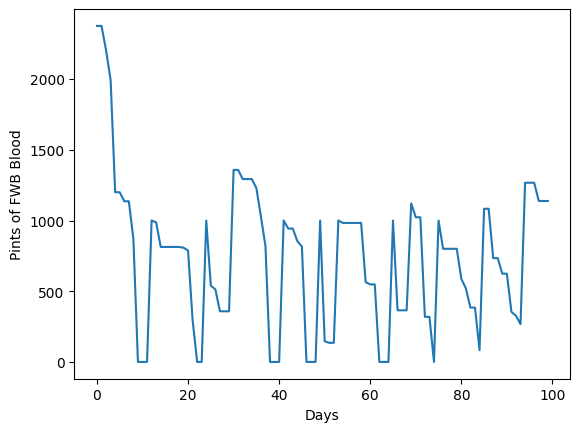

In [ ]:
plt.plot(FWBinventory)
plt.xlabel("Days")
plt.ylabel("Pints of FWB Blood")

Text(0, 0.5, 'Unmet Pints of FWB Blood ')

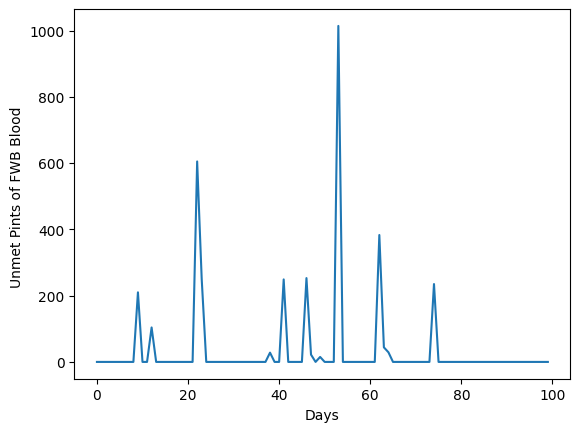

In [ ]:
plt.plot(unMetFWBDemand)
plt.xlabel("Days")
plt.ylabel("Unmet Pints of FWB Blood ")

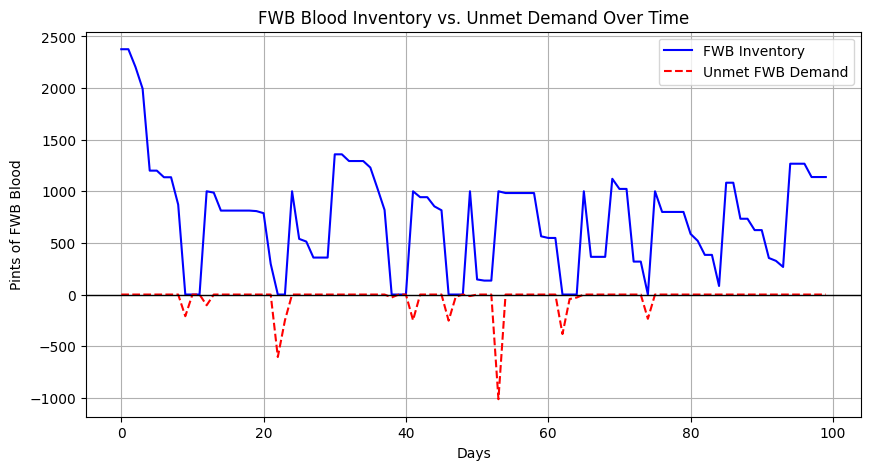

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(FWBinventory, label="FWB Inventory", color='blue')

plt.plot([-x for x in unMetFWBDemand], label="Unmet FWB Demand", color='red', linestyle='dashed')

plt.xlabel("Days")
plt.ylabel("Pints of FWB Blood")
plt.title("FWB Blood Inventory vs. Unmet Demand Over Time")
plt.axhline(0, color='black', linewidth=1)  # Reference line at zero
plt.legend()
plt.grid(True)

plt.show()

Text(0, 0.5, 'Pints of Plasma')

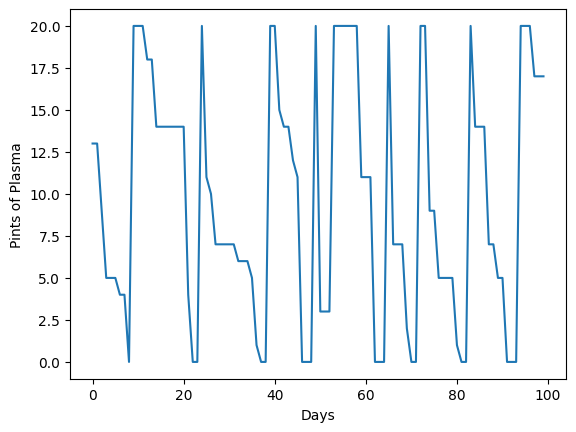

In [ ]:
plt.plot(Plasmainventory)
plt.xlabel("Days")
plt.ylabel("Pints of Plasma")

Text(0, 0.5, 'Unmet Pints of Plasma ')

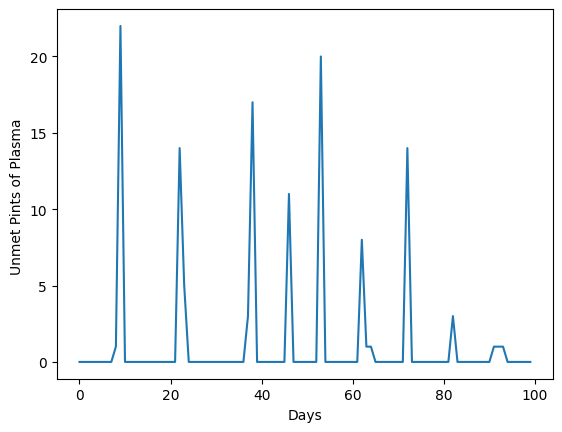

In [ ]:
plt.plot(unMetPlasmaDemand)
plt.xlabel("Days")
plt.ylabel("Unmet Pints of Plasma ")

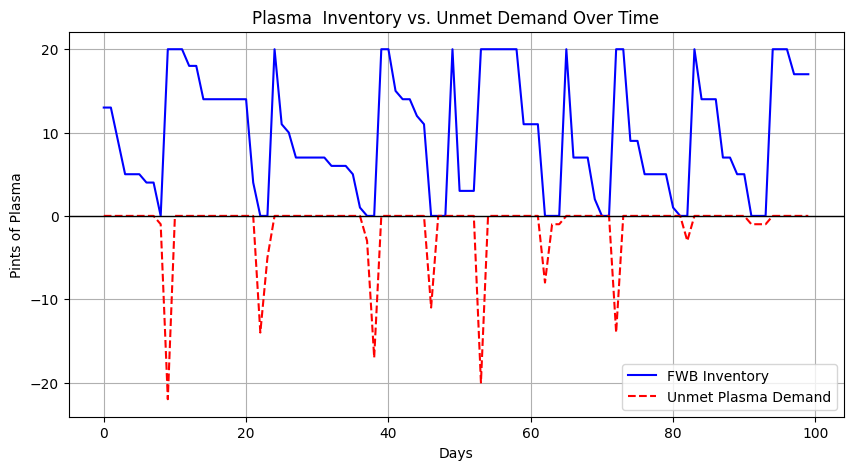

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(Plasmainventory, label="FWB Inventory", color='blue')

plt.plot([-x for x in unMetPlasmaDemand], label="Unmet Plasma Demand", color='red', linestyle='dashed')

plt.xlabel("Days")
plt.ylabel("Pints of Plasma")
plt.title("Plasma  Inventory vs. Unmet Demand Over Time")
plt.axhline(0, color='black', linewidth=1)  # Reference line at zero
plt.legend()
plt.grid(True)

plt.show()

## with optimal Q/R

In [ ]:

Q_FWB = 686
Q_Plasma = 13
R_FWB = 1519
R_Plasma = 34

In [ ]:
#input Cell
platoon1 = Platoon(2, [], [], [0.5, 0.2, 0.1, 0.05, 0.05], [[500, 1000], [5, 20]])
platoon1.addInventory(BloodInventoryUnit(10, 'FWB', 200))
platoon1.addInventory(BloodInventoryUnit(300, 'Plasma', 20))
platoon1.addInventory(BloodInventoryUnit(5, 'FWB', 1500))
platoon1.addInventory(BloodInventoryUnit(15, 'FWB', 1000))

In [ ]:
Opt_FWBinventory = []
Opt_plasmainventory = []
Opt_unMetFWBDemand = []
Opt_unMetPlasmaDemand = []
for i in range(100):
  out = platoon1.usage()
  platoon1.timeStep()
  platoon1.placeOrderCheck()
  Opt_FWBinventory.append(platoon1.totalInventory()[0])
  Opt_plasmainventory.append(platoon1.totalInventory()[1])
  Opt_unMetFWBDemand.append(out[0])
  Opt_unMetPlasmaDemand.append(out[1])

Text(0, 0.5, 'Pints of FWB Blood')

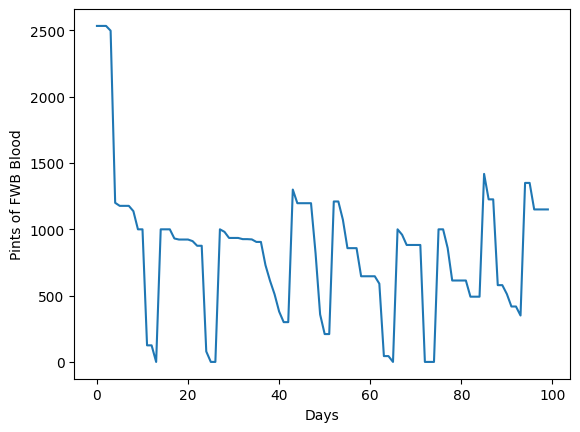

In [ ]:
plt.plot(Opt_FWBinventory)
plt.xlabel("Days")
plt.ylabel("Pints of FWB Blood")

(0.0, 1300.0)

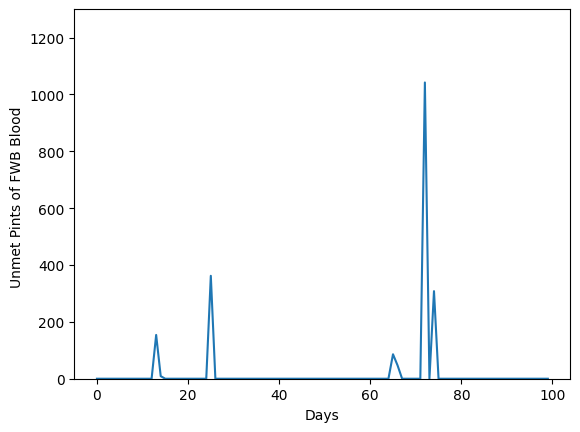

In [ ]:
plt.plot(Opt_unMetFWBDemand)
plt.xlabel("Days")
plt.ylabel("Unmet Pints of FWB Blood ")
plt.ylim(0,1300)

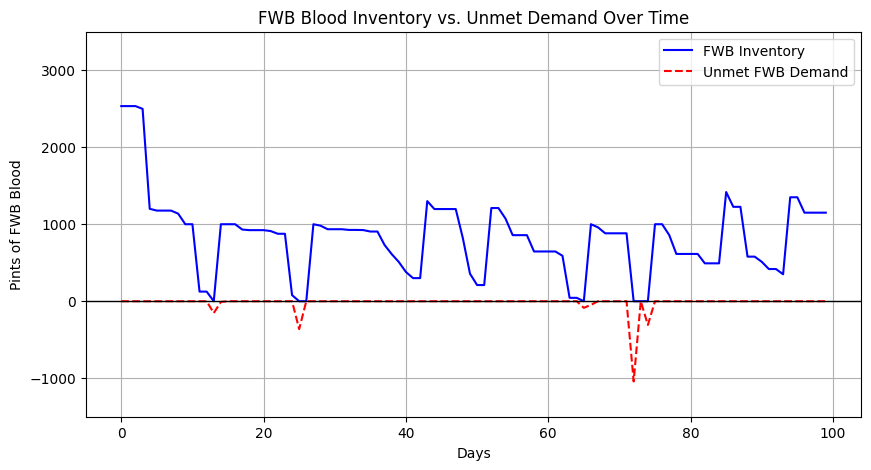

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(Opt_FWBinventory, label="FWB Inventory", color='blue')

plt.plot([-x for x in Opt_unMetFWBDemand], label="Unmet FWB Demand", color='red', linestyle='dashed')

plt.xlabel("Days")
plt.ylabel("Pints of FWB Blood")
plt.title("FWB Blood Inventory vs. Unmet Demand Over Time")
plt.axhline(0, color='black', linewidth=1)  # Reference line at zero
plt.legend()
plt.grid(True)
plt.ylim(-1500,3500)

plt.show()

Text(0, 0.5, 'Pints of Plasma')

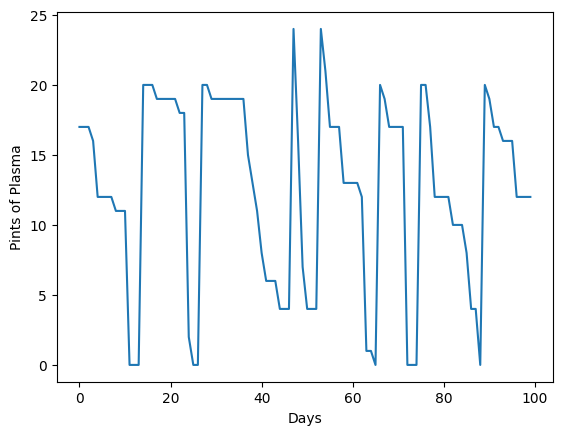

In [ ]:
plt.plot(Opt_plasmainventory)
plt.xlabel("Days")
plt.ylabel("Pints of Plasma")

(0.0, 30.0)

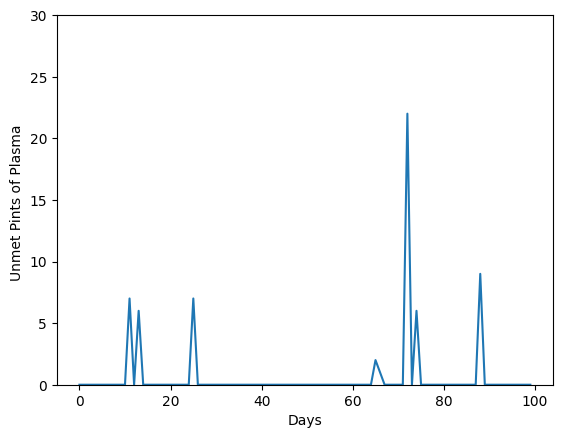

In [ ]:
plt.plot(Opt_unMetPlasmaDemand)
plt.xlabel("Days")
plt.ylabel("Unmet Pints of Plasma ")
plt.ylim(0,30)

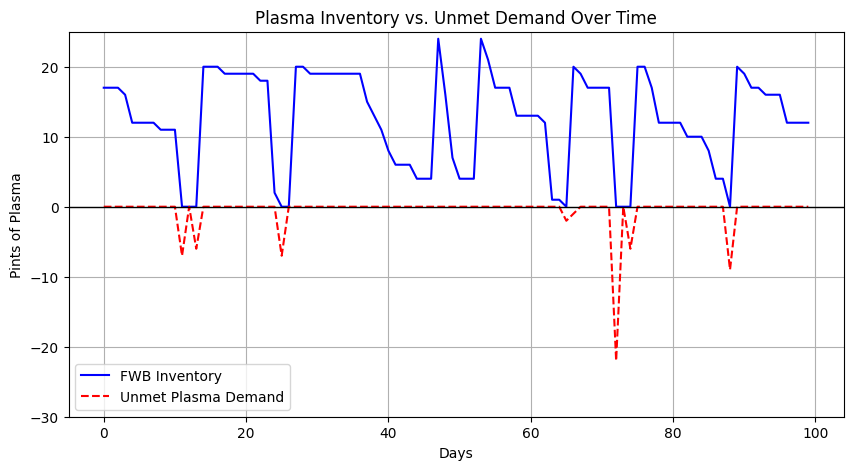

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(Opt_plasmainventory, label="FWB Inventory", color='blue')

plt.plot([-x for x in Opt_unMetPlasmaDemand], label="Unmet Plasma Demand", color='red', linestyle='dashed')

plt.xlabel("Days")
plt.ylabel("Pints of Plasma")
plt.title("Plasma Inventory vs. Unmet Demand Over Time")
plt.axhline(0, color='black', linewidth=1)  # Reference line at zero
plt.legend()
plt.grid(True)
plt.ylim(-30,25)

plt.show()

## Company Code Testing

In [ ]:
platoon2 = Platoon(3, [BloodInventoryUnit(10, 'FWB', 750)], [BloodInventoryUnit(300, 'Plasma', 30)], [0.5, 0.2, 0.1, 0.05, 0.05], [[750, 1500], [10, 35]])

In [ ]:
company1 = Company([], [], [], [platoon1, platoon2])
for i in company1.platoonList:
  print(i.print())


Location: 2 FWB Inventory: [<__main__.BloodInventoryUnit object at 0x7d81ec345d50>] Plasma Inventory: [] Combat Level: 1 Order Placement: [[0], [<__main__.BloodInventoryUnit object at 0x7d81ec346450>]]
Location: 3 FWB Inventory: [<__main__.BloodInventoryUnit object at 0x7d81d87c9a90>] Plasma Inventory: [<__main__.BloodInventoryUnit object at 0x7d81d872d510>] Combat Level: 1 Order Placement: [[], []]


In [ ]:
company1.timeStep()
for i in company1.platoonList:
  print(i.print())


Location: 2 FWB Inventory: [<__main__.BloodInventoryUnit object at 0x7d81ec345d50>] Plasma Inventory: [<__main__.BloodInventoryUnit object at 0x7d81ec346450>] Combat Level: 2 Order Placement: [[], []]
Location: 3 FWB Inventory: [<__main__.BloodInventoryUnit object at 0x7d81d87c9a90>] Plasma Inventory: [<__main__.BloodInventoryUnit object at 0x7d81d872d510>] Combat Level: 1 Order Placement: [[3], [<__main__.BloodInventoryUnit object at 0x7d81d86b4090>]]


## User Input

In [ ]:
T = 100 #Number of days simulated
n = 2 #Number of Platoons
l = [3, 2] #List of length n of the Locations of each platoon as an integer number of days from company location
I = [[[10, 'FWB', 750], [300, 'Plasma', 30]], [[20, 'Plasma', 40], [5, 'FWB', 300], [20, 'FWB', 800]]] #List of length n with an entry for each platoon. Each entry is the platoon current inventory represented by a list of lists of format
# [Days until Expired, Type of blood, number of units]
CLMatrix = [[0.5, 0.2, 0.1, 0.05, 0.05], [0.7, 0.2, 0.05, 0.03, 0.02]] #List of length n of a list of the probability of being at each combat level 0 to 4 for each platoon. Probabilities must add to 1.
QR = [[[400, 1800], [5, 30]], [[500, 1000], [5, 20]]] # List of length n with an entry for each platoon. Each entry is the Q and R values to be tested for said platoon given by a list with an entry for each
#blood category of the form [R, Q]. Q + R must be less than the platoon's storage capacity.
SC = [2500, 2000] #list of length n of the storage capacity in units for each platoon

In [ ]:
platoons = []
for i in range(n):
  FWBInv = []
  PlasmaInv = []
  for j in I[i]:
    if j[1] == 'FWB':
      FWBInv.append(BloodInventoryUnit(j[0], j[1], j[2]))
    if j[1] == 'Plasma':
      PlasmaInv.append(BloodInventoryUnit(j[0], j[1], j[2]))
  platoons.append(Platoon(l[i], FWBInv, PlasmaInv, CLMatrix[i], QR[i]))

## User Input Simulation Test

In [ ]:
Company1 = Company([], [], [], platoons)

In [ ]:
result = []
for i in range(T):
  output = Company1.timeStep()
  result.append(output)

In [ ]:
result = np.array(result).T


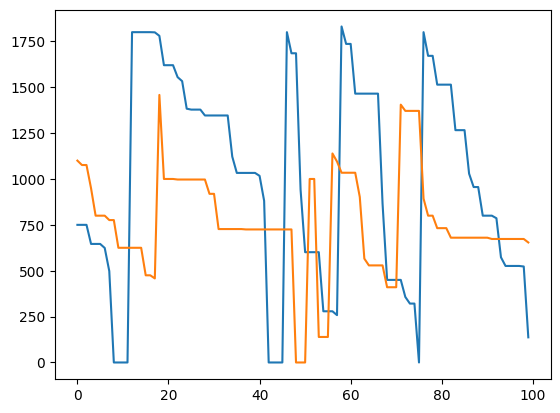

In [ ]:
plt.plot(result[0][2])
plt.plot(result[1][2])

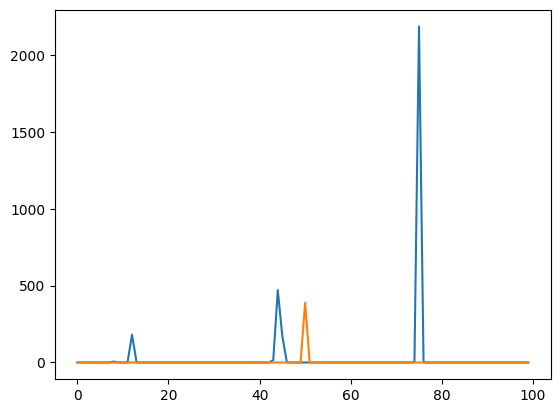

In [ ]:
plt.plot(result[0][0])
plt.plot(result[1][0])

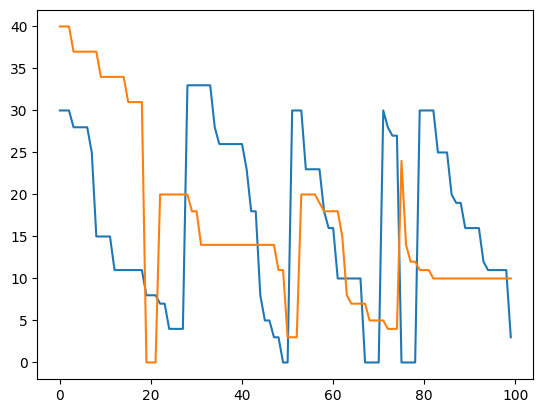

In [ ]:
plt.plot(result[0][3])
plt.plot(result[1][3])

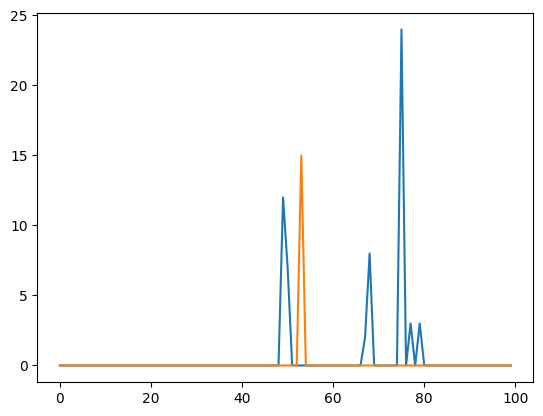

In [ ]:
plt.plot(result[0][1])
plt.plot(result[1][1])

In [ ]:
k = 10
rawScore = 0
maxUnmet = 0
for i in result:
  rawScore += sum(i[0]) + sum(i[1])
  for j in i[0]:
    if j > maxUnmet:
      maxUnmet = j
  for j in i[1]:
    if j > maxUnmet:
      maxUnmet = j
rawScore += maxUnmet * k
normalizeScore = rawScore / (n*T)

In [ ]:
print(rawScore)
print(normalizeScore)

25363
126.815


## Simulation

In [ ]:
!pip install scikit-optimize
from skopt import gp_minimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
def sim(inputs):
  simQR = [[[inputs[0], inputs[1]], [inputs[2], inputs[3]]], [[inputs[4], inputs[5]], [inputs[6], inputs[7]]]]
  platoons = []
  for i in range(n):
    FWBInv = []
    PlasmaInv = []
    for j in I[i]:
      if j[1] == 'FWB':
       FWBInv.append(BloodInventoryUnit(j[0], j[1], j[2]))
      if j[1] == 'Plasma':
        PlasmaInv.append(BloodInventoryUnit(j[0], j[1], j[2]))
    platoons.append(Platoon(l[i], FWBInv, PlasmaInv, CLMatrix[i], simQR[i]))

  Company1 = Company([], [], [], platoons)
  result = []
  for i in range(T):
    output = Company1.timeStep()
    result.append(output)

  result = np.array(result).T
  k = 10
  rawScore = 0
  maxUnmet = 0
  for i in result:
    rawScore += sum(i[0]) + sum(i[1])
    for j in i[0]:
      if j > maxUnmet:
        maxUnmet = j
    for j in i[1]:
      if j > maxUnmet:
        maxUnmet = j
  rawScore += maxUnmet * k
  normalizeScore = rawScore / (n*T)
  return normalizeScore

In [ ]:
bounds = [(200, 800), (500, 2000), (0, 15), (10, 50), (200, 800), (500, 2000), (0, 15), (10, 50)]

result = gp_minimize(sim, bounds, n_calls=100)
print(f"Best configuration: {result.x} with score: {result.fun}")

Best configuration: [686, 1519, 4, 30, 434, 784, 14, 40] with score: 1.17
